In [2]:
pip install transformers datasets accelerate -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 30.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pandas as pd
file_path = '/content/drive/My Drive/data 2/UpdatedResumeDataSet.csv'
try:
    df = pd.read_csv(file_path, encoding='latin-1')
except UnicodeDecodeError:
    try:
        df = pd.read_csv(file_path, encoding='ISO-8859-1')
    except UnicodeDecodeError:
        df = pd.read_csv(file_path, encoding='cp1252')

print(df.head())

       Category                                             Resume
0  Data Science  Skills * Programming Languages: Python (pandas...
1  Data Science  Education Details \r\nMay 2013 to May 2017 B.E...
2  Data Science  Areas of Interest Deep Learning, Control Syste...
3  Data Science  Skills Ã¢ÂÂ¢ R Ã¢ÂÂ¢ Python Ã¢ÂÂ¢ SAP HANA ...
4  Data Science  Education Details \r\n MCA   YMCAUST,  Faridab...


In [6]:
le = LabelEncoder()
df['labels'] = le.fit_transform(df['Category'])

# Split into train and test
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['Resume'].tolist(), df['labels'].tolist(), test_size=0.2, random_state=42)

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [8]:
class ResumeDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

    def __len__(self):
        return len(self.labels)

train_dataset = ResumeDataset(train_encodings, train_labels)
val_dataset = ResumeDataset(val_encodings, val_labels)


In [9]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(set(train_labels)))


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    eval_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

In [11]:
trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: zwaseem298 (zwaseem298-fast-nuces) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,2.968200,2.885286
2,2.505700,2.349889
3,1.536400,1.409181


TrainOutput(global_step=291, training_loss=2.6085066664259866, metrics={'train_runtime': 340.7002, 'train_samples_per_second': 6.771, 'train_steps_per_second': 0.854, 'total_flos': 607122554323968.0, 'train_loss': 2.6085066664259866, 'epoch': 3.0})

In [12]:
trainer.evaluate()


{'eval_loss': 1.4091806411743164,
 'eval_runtime': 5.8757,
 'eval_samples_per_second': 32.847,
 'eval_steps_per_second': 4.255,
 'epoch': 3.0}

In [14]:
# Make predictions
predictions = trainer.predict(val_dataset)

# Get predicted labels (argmax of logits)
preds = torch.argmax(torch.tensor(predictions.predictions), axis=1)


In [15]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [16]:
# Accuracy
acc = accuracy_score(val_labels, preds)
print(f"Accuracy: {acc:.4f}")

# Classification Report (includes F1, precision, recall)
target_names = le.classes_
print(classification_report(val_labels, preds, target_names=target_names))


Accuracy: 0.8394
                           precision    recall  f1-score   support

                 Advocate       1.00      1.00      1.00         3
                     Arts       1.00      0.83      0.91         6
       Automation Testing       0.00      0.00      0.00         5
               Blockchain       1.00      1.00      1.00         7
         Business Analyst       0.00      0.00      0.00         4
           Civil Engineer       1.00      0.56      0.71         9
             Data Science       0.71      1.00      0.83         5
                 Database       1.00      1.00      1.00         8
          DevOps Engineer       0.62      0.93      0.74        14
         DotNet Developer       0.00      0.00      0.00         5
            ETL Developer       1.00      0.57      0.73         7
   Electrical Engineering       1.00      1.00      1.00         6
                       HR       1.00      1.00      1.00        12
                   Hadoop       0.57      1.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


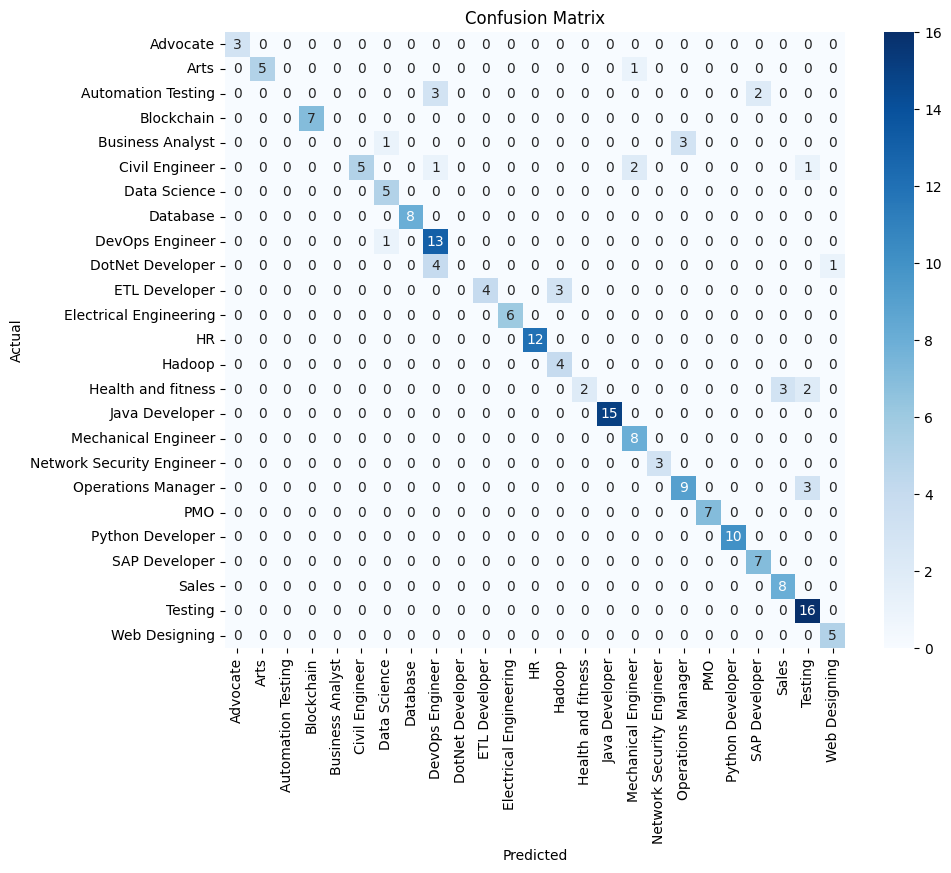

In [17]:
# Confusion matrix
cm = confusion_matrix(val_labels, preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [25]:
new_resume_text = """
Experienced software engineer with strong background in Python, machine learning, and backend development.
Worked on multiple AI-based products including recommendation systems, NLP pipelines, and cloud deployment.
Proficient in Docker, AWS, and Git. Passionate about solving real-world problems using AI.
"""
#new_resume_text = "Graduate with strong communication skills and experience in recruitment, payroll, and performance appraisal systems. Seeking HR role."

#new_resume_text = "Web developer skilled in HTML, CSS, JavaScript, React and Node.js. Built responsive and dynamic web applications."



In [26]:
# Tokenize and encode the input
inputs = tokenizer(new_resume_text, return_tensors="pt", truncation=True, padding=True, max_length=512)


In [27]:
# Move to GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Get prediction logits
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
predicted_class_id = logits.argmax().item()

# Decode to class label
predicted_label = le.inverse_transform([predicted_class_id])[0]
print(f"Predicted Resume Category: {predicted_label}")


Predicted Resume Category: DevOps Engineer


In [28]:
# Save the model and tokenizer to a folder
model.save_pretrained("bert-resume-classifier")
tokenizer.save_pretrained("bert-resume-classifier")


('bert-resume-classifier/tokenizer_config.json',
 'bert-resume-classifier/special_tokens_map.json',
 'bert-resume-classifier/vocab.txt',
 'bert-resume-classifier/added_tokens.json')